In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sb
import matplotlib.ticker as ticker
import scipy.stats as sp
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import scipy
import math

import xgboost as xgb
from xgboost import plot_importance, plot_tree

%matplotlib inline

In [2]:
sample_df = pd.read_csv("Prepared_dataset.csv")
sample_df['date']  = pd.to_datetime(sample_df['date'], format = '%Y-%m-%d')
sample_df = sample_df.set_index('date')

In [8]:
end_date = '01-Mar-2022'

### Synthetically projecting Vaccination ratio

- We know that vaccination has started roughly from Jan-2021. We use these dates to fit the linear regression model from Jan-2021 until 01-May-2021
- From 01-May-2021 until Jun-23 we can see the models performance on this test set

In [3]:
start_date = '01-Jan-2021'
vaccination_df = sample_df.loc[sample_df.index>=start_date].copy()

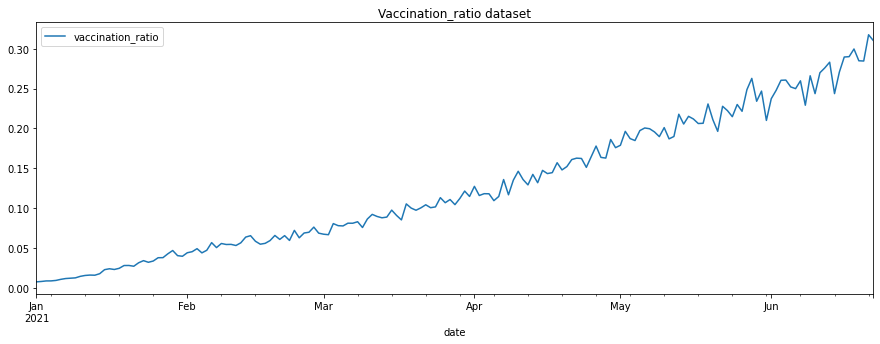

In [4]:
vaccination_df = vaccination_df.drop(['new_deaths_per_million','reproduction_rate','positive_rate','stringency_index'],axis=1)

_ = vaccination_df.plot(figsize=(15,5), title='Vaccination_ratio dataset')

In [5]:
# To have a reference from a start date 
vaccination_df['days_from_start'] = (vaccination_df.index - vaccination_df.index[0]).days

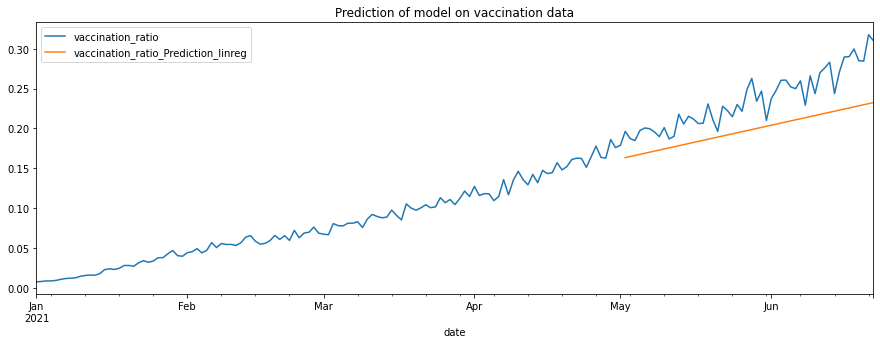

In [6]:
split_date = '01-May-2021'
vaccination_df_train = vaccination_df.loc[vaccination_df.index <= split_date].copy()
vaccination_df_test = vaccination_df.loc[vaccination_df.index > split_date].copy()

X_train = vaccination_df_train.drop(['vaccination_ratio'],axis=1)
y_train = pd.DataFrame(vaccination_df_train['vaccination_ratio'])

X_test = vaccination_df_test.drop(['vaccination_ratio'],axis=1)
y_test = pd.DataFrame(vaccination_df_test['vaccination_ratio'])

model = linear_model.LinearRegression().fit(X_train, y_train)#
vaccination_df_test['vaccination_ratio_Prediction_linreg'] = model.predict(X_test) 

vaccination_df_all = pd.concat([vaccination_df_train,vaccination_df_test], sort=False)
_ = vaccination_df_all[['vaccination_ratio','vaccination_ratio_Prediction_linreg']].plot(figsize=(15, 5),title="Prediction of model on vaccination data")

> We see that vaccination ratio is not exactly linear. It is more of exponential. This can b explained by the fact that there are more vaccination drives happening and people are getting vaccinated faster w.r.t time
> Alternative is to go ahead to fit the vaccation_ratio using a simple Neural network which can handle curves
   - The vaccination ratio has a max_limit of 1, so we can go ahead and use a sigmoid function in our final layer of NN
   - The hidden layer

In [47]:
days = pd.date_range(start='2021-06-22', end=end_date)
projection_10_months = pd.DataFrame(data=days, index = range(len(days)), columns=['date'])
projection_10_months = projection_10_months.set_index('date')
#projection_10_months = vaccination_df.append(projection_10_months)

In [48]:
projection_10_months['days_from_start'] = (projection_10_months.index - vaccination_df.index[0]).days

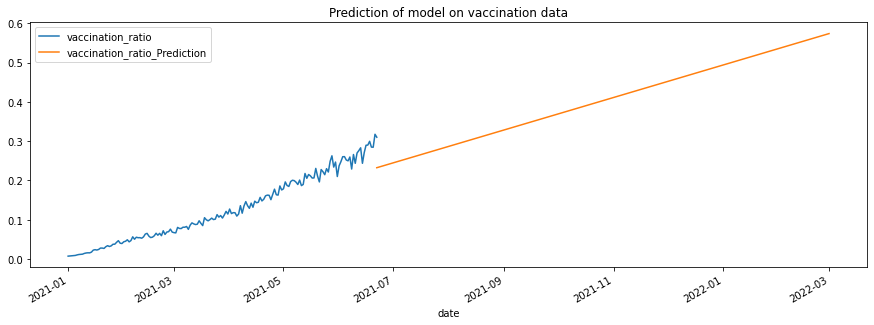

In [49]:
projection_10_months['vaccination_ratio_Prediction'] = model.predict(projection_10_months) 
projection_10_months = vaccination_df.append(projection_10_months)
_ = projection_10_months[['vaccination_ratio','vaccination_ratio_Prediction']].plot(figsize=(15, 5),title="Prediction of model on vaccination data")

This is our synthetic data, however this can be improved by using a simple neural network to capture the non linearity mentioned previously. 

### Synthetically projecting Stringency Index


In [51]:
projection_10_months

,vaccination_ratio,days_from_start,vaccination_ratio_Prediction
date,,,
2021-01-01,0.007594,0,NaN
2021-01-02,0.008064,1,NaN
2021-01-03,0.008740,2,NaN
2021-01-04,0.008787,3,NaN
2021-01-05,0.009376,4,NaN
...,...,...,...
2022-02-25,NaN,420,0.568253
2022-02-26,NaN,421,0.569607
2022-02-27,NaN,422,0.570961


In [53]:
stringency_df = sample_df.drop(sample_df.columns.difference(['stringency_index']), 1, inplace=False)

c:\users\bhara\anaconda3\envs\aimed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\bhara\anaconda3\envs\aimed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\bhara\anaconda3\envs\aimed\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:       stringency_index   No. Observations:                  487
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -374.523
Date:                Sat, 26 Jun 2021   AIC                            761.045
Time:                        19:08:25   BIC                            786.162
Sample:                    01-01-2020   HQIC                           770.913
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1153      0.015      7.450      0.000       0.085       0.146
ar.L2          0.2148      0.025      8.610      0.000       0.166       0.264
ar.L3          0.4650      0.019     24.522      0.0

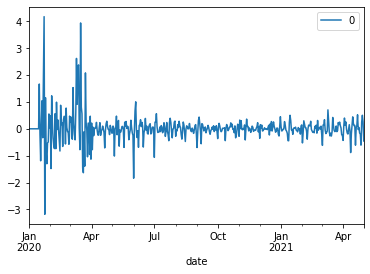

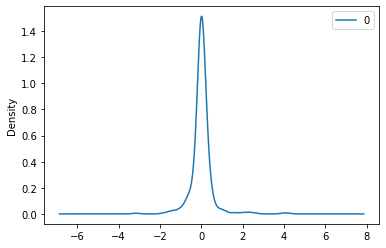

                0
count  487.000000
mean     0.016696
std      0.521887
min     -3.181491
25%     -0.117668
50%      0.000000
75%      0.135486
max      4.173061


In [60]:
split_date = '01-May-2021'
stringency_df_train = stringency_df.loc[stringency_df.index <= split_date].copy()
stringency_df_test = stringency_df.loc[stringency_df.index > split_date].copy()

X_train = stringency_df_train.drop(['stringency_index'],axis=1)
y_train = pd.DataFrame(stringency_df_train['stringency_index'])

X_test = stringency_df_test.drop(['stringency_index'],axis=1)
y_test = pd.DataFrame(stringency_df_test['stringency_index'])

# fit model
model = ARIMA(stringency_df_train, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [99]:
for t in range(len(stringency_df)):
    model = ARIMA(stringency_df_train, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    obs = test[t]
    stringency_df_test.at[stringency_df_test.index[-1]+timedelta(days=1),'stringency_index_predictions'] = yhat
    print('predicted=%f, expected=%f' % (yhat, obs))
model_fit.forecast()

2021-06-23    51.81349
Freq: D, dtype: float64

In [ ]:
model = ARIMA(stringency_df_train, order=(5,1,0))
model_fit = model.fit()
model_fit.forecast()

In [108]:
stringency_df_train.append(projection_10_months,ignore_index=True)

,stringency_index
date,
2020-01-01,0.000000
2020-01-02,0.000000
2020-01-03,0.000000
2020-01-04,0.000000
2020-01-05,0.000000
...,...
2021-04-27,56.592222
2021-04-28,56.754167
2021-04-29,57.080889


In [111]:
stringency_df_train

,stringency_index
date,
2020-01-01,0.000000
2020-01-02,0.000000
2020-01-03,0.000000
2020-01-04,0.000000
2020-01-05,0.000000
...,...
2021-04-28,56.754167
2021-04-29,57.080889
2021-04-30,57.137444
